<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/Sensor15_epoche.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:

import os
from IPython.core.completer import time
from natsort import natsorted
from tensorflow.keras.preprocessing.image import (
    array_to_img,
    img_to_array,
    load_img,
)
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np


In [3]:
class GetLoader:
    def __init__(self, *, imgs, masks, timesteps, batch_size, squeeze=False):
        self.imgs = imgs
        self.masks = masks
        self.timesteps = timesteps
        self.batch_size = batch_size
        self.squeeze = squeeze
        self.augmentation = tf.keras.Sequential(
            [
                layers.RandomFlip("horizontal_and_vertical"),
                layers.RandomRotation(0.2),


            ]
        )

    def __iter__(self):
        return self

    def __next__(self):
        xs = []
        ys = []
        for _ in range(self.batch_size):
            index = np.random.randint(0, len(self.imgs) - self.timesteps)
            xs.append(self.imgs[index : index + self.timesteps])
            ys.append(self.masks[index + self.timesteps])
        x, y = np.array(xs), np.array(ys)
        x = x.squeeze(-1).transpose(0, 2, 3, 1)
        xy = self.augmentation(tf.concat((x, y), axis=-1))

        x = xy[:, :, :, :3]
        y = xy[:, :, :, 3:]
        if not self.squeeze:
            x = tf.transpose(x, perm=(0, 3, 1, 2))[..., None]
            y = tf.expand_dims(y, 1)
        # if not tf.reduce_all(y[0] == 0):
        #    ipdb.set_trace()
        return x, y


class DataLoader:
    def __init__(
        self,
        data_folder: str,
        *,
        timesteps: int = 3,
        batch_size=4,
        squeeze=False,
    ):
        self.batch_size = batch_size
        self.data_folder = data_folder
        self.timesteps = timesteps
        self.squeeze = squeeze
        train_img_file_names = [
            os.path.join(data_folder, "train_images", "images", fn)
            for fn in os.listdir(os.path.join(data_folder, "train_images", "images"))
        ]
        train_img_file_names = natsorted(train_img_file_names)
        # train_img_file_names.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
        train_mask_file_names = [
            fn.replace("images", "masks") for fn in train_img_file_names
        ]
        self.train_imgs = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in train_img_file_names
                ]
            )
            / 255
        )
        self.train_masks = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in train_mask_file_names
                ]
            )
            / 255
            > 0.5
        ).astype(float)

        val_img_file_names = [
            os.path.join(data_folder, "val_images", "images", fn)
            for fn in os.listdir(os.path.join(data_folder, "val_images", "images"))
        ]
        val_img_file_names = natsorted(val_img_file_names)
        val_mask_file_names = [
            fn.replace("images", "masks") for fn in val_img_file_names
        ]
        self.val_imgs = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in val_img_file_names
                ]
            )
            / 255
        )
        self.val_masks = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in val_mask_file_names
                ]
            )
            / 255
            > 0.5
        ).astype(float)

    def get_loaders(self):
        return (
            GetLoader(
                imgs=self.train_imgs,
                masks=self.train_masks,
                timesteps=self.timesteps,
                batch_size=self.batch_size,
                squeeze=self.squeeze,
            ),
            GetLoader(
                imgs=self.val_imgs,
                masks=self.val_masks,
                timesteps=self.timesteps,
                batch_size=self.batch_size,
                squeeze=self.squeeze,
            ),
        )

In [4]:
train_loader, val_loader = DataLoader("/gdrive/MyDrive/adjustedROI/final_output", squeeze=False).get_loaders()


In [5]:
x, y = train_loader.__next__()

In [6]:
from matplotlib import pyplot as plt

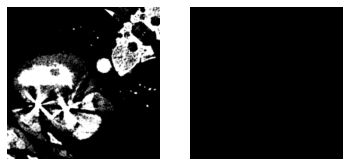

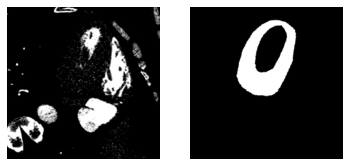

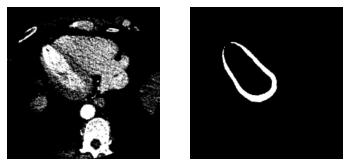

In [7]:
x, y = train_loader.__next__()

for i in range(0,3):
    image = x[i,0,:,:,0]
    #mask = np.argmax(y[i], axis=2)
    mask= y[i,0,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [8]:
x.shape

TensorShape([4, 3, 256, 256, 1])

In [9]:
y.shape


TensorShape([4, 1, 256, 256, 1])

In [10]:
batch_size=4

In [11]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('/gdrive/MyDrive/adjustedROI/final_output/train_images/images'))
num_val_images = len(os.listdir('/gdrive/MyDrive/adjustedROI/final_output/val_images/images'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, TimeDistributed,Dropout,Input, Dense,\
    BatchNormalization, GRU, Layer, Flatten,MaxPooling2D, concatenate,Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras import models
from tensorflow.python.keras.layers import ConvLSTM2D

In [13]:
input_shape=(3,256,256,1)

In [14]:
input_l = layers.Input(shape=(input_shape))
x =  (layers.TimeDistributed(layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1),activation='relu' ) )) (input_l)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
conv2 = layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1),activation='relu'  ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(conv2)

x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(x)
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1),activation='relu'   ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
conv5 = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1),activation='relu'   ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(conv5)
x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(x)
x = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ,activation='relu'  ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)

conv8 = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ,activation='relu'  ) ) (x)
conv8=layers.TimeDistributed(layers.BatchNormalization())(conv8)

x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(conv8)

x=layers.Bidirectional(layers.ConvLSTM2D(256,kernel_size=(3,3),padding='same',strides=(1,1),return_sequences=True,recurrent_dropout=0.2))(x)
up1 = layers.TimeDistributed( layers.Conv2DTranspose( 512,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat1 = layers.concatenate([up1, conv8])
x = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ,activation='relu'  ) ) (concat1)
x = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ,activation='relu'  ) ) (x)
up2 = layers.TimeDistributed( layers.Conv2DTranspose( 256,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat2 = layers.concatenate([up2, conv5])
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1),activation='relu'   ) ) (concat2)
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1) ,activation='relu'  ) ) (x)
up3 = layers.TimeDistributed( layers.Conv2DTranspose( 128,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat3 = layers.concatenate([up3, conv2])
x = layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1),activation='relu'   ) ) (concat3)
x=layers.Bidirectional(layers.ConvLSTM2D(32,kernel_size=(3,3),padding='same',strides=(1,1),return_sequences=False,recurrent_dropout=0.2))(x)
x=tf.expand_dims(x,axis=1)

#out= layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(1, 1),padding='same',strides=(1,1),activation='relu' ,  ) ) (x)
#out = tf.reshape(out, (-1, 1, 256,256, 64))
out = layers.Conv2D( 1, kernel_size=(1, 1),padding='same',strides=(1,1), activation='sigmoid' )  (x)


model = models.Model(inputs=input_l, outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 256, 256  0           []                               
                                , 1)]                                                             
                                                                                                  
 time_distributed (TimeDistribu  (None, 3, 256, 256,  640        ['input_1[0][0]']                
 ted)                            64)                                                              
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 3, 256, 256,  256        ['time_distributed[0][0]']       
 buted)                          64)                                                          

In [15]:
from keras import backend as K


def dice_coefficient(y_true, y_pred, smooth=0.0001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)

    return ((2. * intersection + smooth) / (K.sum(y_true_f) +
            K.sum(y_pred_f) + smooth))


def dice_coefficient_loss(y_true, y_pred):
    return 1.0-dice_coefficient(y_true, y_pred)


def iou_loss(y_true, y_pred):
    return 1-iou(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum(K.square(y_true)) + K.sum(K.square(y_pred))
    jac = (intersection) / (sum_ - intersection)
    return jac

In [16]:
LR = 5e-5
optim = tf.keras.optimizers.Adam(LR)

In [17]:
metrics=['Recall','Precision', dice_coefficient, 'binary_accuracy']


In [18]:
model.compile(optimizer=optim, loss=dice_coefficient_loss, metrics=metrics)


In [19]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/gdrive/MyDrive/chk/',
    save_weights_only=True,
    monitor='val_dice_coefficient',
    mode='max',
    save_best_only=True)


In [20]:
history=model.fit(train_loader,
          steps_per_epoch=steps_per_epoch,
          epochs=15,
          verbose=1,
          validation_data=val_loader,
          callbacks=model_checkpoint_callback,

    
          validation_steps=val_steps_per_epoch)

Epoch 1/15
745/745 [==============================] - 1209s 2s/step - loss: 0.5763 - recall: 0.6275 - precision: 0.2647 - dice_coefficient: 0.4237 - binary_accuracy: 0.9469 - val_loss: 0.5419 - val_recall: 0.5072 - val_precision: 0.5376 - val_dice_coefficient: 0.4581 - val_binary_accuracy: 0.9715
Epoch 2/15
745/745 [==============================] - 1183s 2s/step - loss: 0.4568 - recall: 0.6687 - precision: 0.5879 - dice_coefficient: 0.5432 - binary_accuracy: 0.9793 - val_loss: 0.4329 - val_recall: 0.6890 - val_precision: 0.6032 - val_dice_coefficient: 0.5671 - val_binary_accuracy: 0.9735
Epoch 3/15
745/745 [==============================] - 1181s 2s/step - loss: 0.4257 - recall: 0.6756 - precision: 0.6263 - dice_coefficient: 0.5743 - binary_accuracy: 0.9806 - val_loss: 0.3707 - val_recall: 0.6389 - val_precision: 0.7210 - val_dice_coefficient: 0.6293 - val_binary_accuracy: 0.9790
Epoch 4/15
745/745 [==============================] - 1180s 2s/step - loss: 0.4000 - recall: 0.7015 - prec

In [21]:
model.save('/gdrive/MyDrive/SensorAdjusted-15epochs-5e-5-savethebestonly-recurrent0.2-.h5')


In [22]:
#Load previously saved model
from keras.models import load_model
model = load_model("/gdrive/MyDrive/SensorAdjusted-15epochs-5e-5-savethebestonly-recurrent0.2-.h5", compile=False)

In [23]:
class GetLoader:
    def __init__(self, *, imgs, masks, timesteps, batch_size, squeeze=False):
        self.imgs = imgs
        self.masks = masks
        self.timesteps = timesteps
        self.batch_size = batch_size
        self.squeeze = squeeze
        self.augmentation = tf.keras.Sequential(
            [
                layers.RandomFlip("horizontal_and_vertical"),
                layers.RandomRotation(0.2),
            ]
        )

    def __iter__(self):
        return self

    def __next__(self):
        xs = []
        ys = []
        for _ in range(self.batch_size):
            index = np.random.randint(0, len(self.imgs) - self.timesteps)
            xs.append(self.imgs[index : index + self.timesteps])
            ys.append(self.masks[index + self.timesteps])
        x, y = np.array(xs), np.array(ys)
        x = x.squeeze(-1).transpose(0, 2, 3, 1)
        xy = self.augmentation(tf.concat((x, y), axis=-1))

        x = xy[:, :, :, :3]
        y = xy[:, :, :, 3:]
        if not self.squeeze:
            x = tf.transpose(x, perm=(0, 3, 1, 2))[..., None]
            y = tf.expand_dims(y, 1)
        # if not tf.reduce_all(y[0] == 0):
        #    ipdb.set_trace()
        return x, y


class DataLoader:
    def __init__(
        self,
        data_folder: str,
        *,
        timesteps: int = 3,
        batch_size=400,
        squeeze=False,
    ):
        self.batch_size = batch_size
        self.data_folder = data_folder
        self.timesteps = timesteps
        self.squeeze = squeeze
        train_img_file_names = [
            os.path.join(data_folder, "train_images", "images", fn)
            for fn in os.listdir(os.path.join(data_folder, "train_images", "images"))
        ]
        train_img_file_names = natsorted(train_img_file_names)
        # train_img_file_names.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
        train_mask_file_names = [
            fn.replace("images", "masks") for fn in train_img_file_names
        ]
        self.train_imgs = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in train_img_file_names
                ]
            )
            / 255
        )
        self.train_masks = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in train_mask_file_names
                ]
            )
            / 255
            > 0.5
        ).astype(float)

        val_img_file_names = [
            os.path.join(data_folder, "val_images", "images", fn)
            for fn in os.listdir(os.path.join(data_folder, "val_images", "images"))
        ]
        val_img_file_names = natsorted(val_img_file_names)
        val_mask_file_names = [
            fn.replace("images", "masks") for fn in val_img_file_names
        ]
        self.val_imgs = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in val_img_file_names
                ]
            )
            / 255
        )
        self.val_masks = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in val_mask_file_names
                ]
            )
            / 255
            > 0.5
        ).astype(float)

    def get_loaders(self):
        return (
            GetLoader(
                imgs=self.train_imgs,
                masks=self.train_masks,
                timesteps=self.timesteps,
                batch_size=self.batch_size,
                squeeze=self.squeeze,
            ),
            GetLoader(
                imgs=self.val_imgs,
                masks=self.val_masks,
                timesteps=self.timesteps,
                batch_size=self.batch_size,
                squeeze=self.squeeze,
            ),
        )

In [24]:
data_folder = "/gdrive/MyDrive/adjustedROI/final_output"
train,val_loader = DataLoader(data_folder, batch_size=477).get_loaders()

In [25]:
a, b = val_loader.__next__()

In [26]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
ground_truth.shape

TensorShape([1, 256, 256, 1])

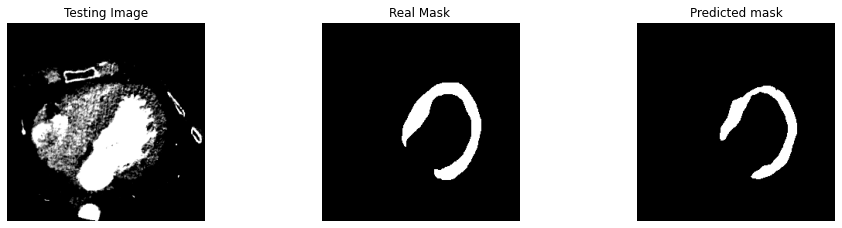

In [52]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)

prediction = (model.predict(test_img_input)[0,0,:,:,0] > 0.5).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.axis('off')
plt.title('Testing Image')
plt.imshow(test_img[0,:,:,0], cmap='gray')


plt.subplot(232)
plt.title('Real Mask ')
plt.axis('off')
plt.imshow(ground_truth[0,:,:,0], cmap='gray')
plt.subplot(233)
plt.axis('off')
plt.title('Predicted mask')
plt.imshow(prediction, cmap='gray')

plt.show()

In [53]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[0,:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8577975


In [55]:
num_val_images = len(os.listdir('/gdrive/MyDrive/adjustedROI/final_output/val_images/images'))
print(num_val_images)

477


In [56]:
import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,0,:,:,0]> 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[0,:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

1.0
0.7602928
1.0
0.4997635
0.50502145
1.0
0.5797482
0.49993134
0.62490904
0.6440548
0.49019623
0.64466226
0.61679435
0.5750706
1.0
0.801533
0.49918365
0.48575592
1.0
1.0
0.87321997
1.0
1.0
0.53741175
0.4975891
0.53741175
0.6058946
0.49993134
1.0
1.0
1.0
0.6041299
0.8577975
0.58980405
1.0
0.54139453
0.5511654
0.592387
0.48138428
0.7982832
0.6040289
0.80954885
0.5797482
0.62490904
0.5395103
0.6040289
0.6453279
1.0
1.0
0.7807131
0.4982311
0.66424406
0.48329926
0.48692322
0.5423883
0.4999237
0.5898627
1.0
0.7344574
1.0
1.0
1.0
0.6772063
0.7081872
0.4999237
0.6513666
0.84376836
0.8261925
0.592387
1.0
0.49491882
1.0
1.0
0.4975891
0.71465147
0.8119811
1.0
0.4923935
0.811051
1.0
0.49153137
0.49860382
0.53558797
0.631341
0.68821144
0.49900818
0.4998169
0.7921154
1.0
1.0
0.4999237
0.6542629
0.5317144
0.62411046
0.49899292
1.0
0.6699565
0.7815497
0.8530511
0.49970245
0.54964596
0.6334889
1.0
0.59478515
0.7245589
0.8119811
0.48529053
0.49999237
0.7245589
0.8530511
0.7454109
0.5750706
0.88888586
1